## Prerequisites

We will use the Transformers library from HuggingFace which is pip-installable:

pip install transformers

You'll also probably want to use PyTorch

In [7]:
pip install transformers torch scikit-learn matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m2/4 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

/Users/andrewzabelo/Desktop/ay119 transformer assignment/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exercise 1: Tokenization and Exbedding Exploration

The aim of this exercise is to visualize how text is broken down into tokens and converted into embeddings. 

1) Create a short ten word sentence
2) Tokenize it using a tokenizer from the Hugging Face model bert-base-uncased
3) Decode the tokens back into words
4) Use the model's embedding layer to project tokens into vectors
5) Visualize the embeddings using PCA

Decoded Tokens: ['[CLS]', 'this', 'is', 'a', 'ten', 'word', 'sentence', 'for', 'my', 'astro', '##physics', 'assignment', '.', '[SEP]']


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


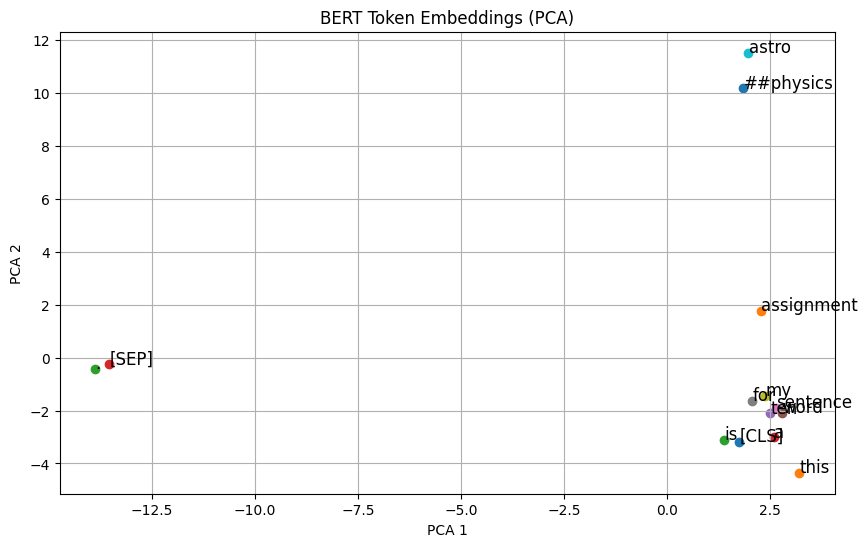

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Sentence
sentence = "This is a ten word sentence for my astrophysics assignment."

# 2. Tokenization using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(sentence, return_tensors="pt")

# 3. Decode token IDs back to tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("Decoded Tokens:", decoded_tokens)

# 4. Load model and get token embeddings
model = AutoModel.from_pretrained("bert-base-uncased")
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_size)

# 5. PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings.numpy())

# 6. Visualization
plt.figure(figsize=(10, 6))
for i, token in enumerate(decoded_tokens):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, token, fontsize=12)

plt.title("BERT Token Embeddings (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


## Exercise 2: Build Your Own Scaled Dot-Product Attention

This exercise gets you familiar with the attention mechanism from scratch on small data.

1) Generate small random matrices for queries, keys, and values
2) Implement the scaled dot-product attention:

$ Attention(Q, K, V) = softmax \left( \frac{QK^T}{\sqrt{d_k}} \right) V $

3) Visualize the attention weights as a heatmap

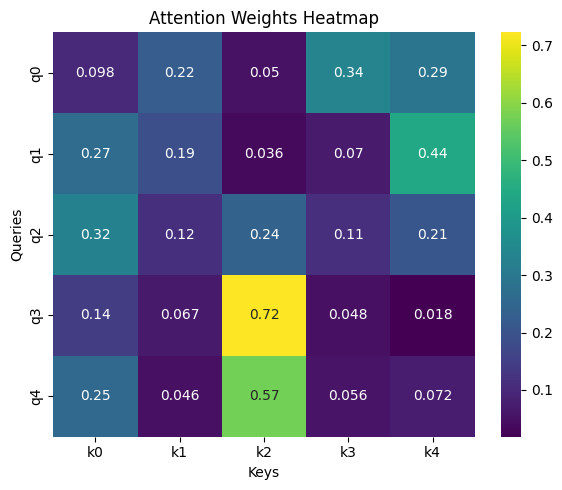

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Generate small random matrices for Q, K, V
torch.manual_seed(0)
batch_size = 1
seq_len = 5
d_k = 4  # dimensionality of keys/queries

Q = torch.randn((batch_size, seq_len, d_k))
K = torch.randn((batch_size, seq_len, d_k))
V = torch.randn((batch_size, seq_len, d_k))

# 2. Scaled dot-product attention
def scaled_dot_product_attention(Q, K, V):
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

attention_output, attention_weights = scaled_dot_product_attention(Q, K, V)

# 3. Visualize attention weights as heatmap
attention_weights_np = attention_weights.squeeze(0).detach().numpy()

plt.figure(figsize=(6, 5))
sns.heatmap(attention_weights_np, annot=True, cmap="viridis", xticklabels=[f"k{i}" for i in range(seq_len)],
            yticklabels=[f"q{i}" for i in range(seq_len)])
plt.title("Attention Weights Heatmap")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.tight_layout()
plt.show()


## Exercise 3: Multi-Head Attention 

This exercise shows how multi-head attention works by implementing a simplified version with synthetic data.

Repeat Ex. (2) with a synthetic input of 3 tokens, each with an 8-d embedding and 3 attention heads

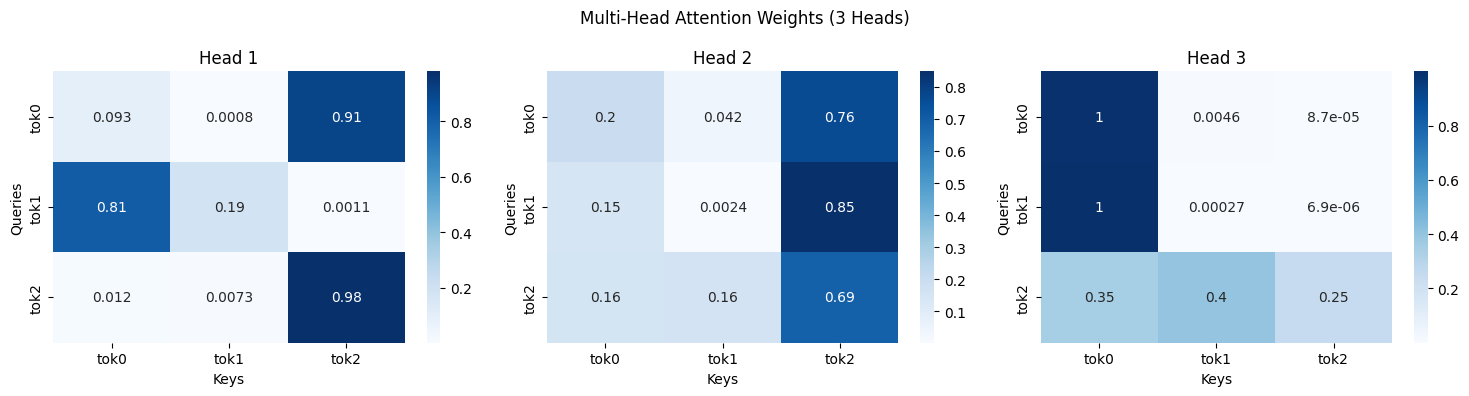

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Synthetic input: 3 tokens with 8-dim embeddings
torch.manual_seed(42)
seq_len = 3
embed_dim = 8
num_heads = 3
head_dim = embed_dim // num_heads  # 8 / 3 = 2.66 —> for simplicity, use 6 instead of 8

embed_dim = 6
head_dim = embed_dim // num_heads  # 6 / 3 = 2

x = torch.randn((1, seq_len, embed_dim))  # shape: (batch_size, seq_len, embed_dim)

# 2. Create projection matrices for Q, K, V per head
W_q = torch.randn((embed_dim, embed_dim))
W_k = torch.randn((embed_dim, embed_dim))
W_v = torch.randn((embed_dim, embed_dim))

# Linear projections
Q = x @ W_q  # (1, seq_len, embed_dim)
K = x @ W_k
V = x @ W_v

# 3. Split into heads
def split_heads(tensor, num_heads):
    batch_size, seq_len, embed_dim = tensor.shape
    head_dim = embed_dim // num_heads
    tensor = tensor.view(batch_size, seq_len, num_heads, head_dim)
    return tensor.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, head_dim)

Q_heads = split_heads(Q, num_heads)
K_heads = split_heads(K, num_heads)
V_heads = split_heads(V, num_heads)

# 4. Scaled dot-product attention for each head
def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

all_attention_weights = []
all_outputs = []

for i in range(num_heads):
    out, weights = scaled_dot_product_attention(Q_heads[0, i], K_heads[0, i], V_heads[0, i])
    all_outputs.append(out)
    all_attention_weights.append(weights.detach().numpy())

# 5. Concatenate outputs from all heads
multihead_output = torch.cat(all_outputs, dim=-1)  # (seq_len, embed_dim)

# 6. Visualize attention weights for each head
fig, axes = plt.subplots(1, num_heads, figsize=(15, 4))

for i in range(num_heads):
    sns.heatmap(all_attention_weights[i], annot=True, cmap="Blues",
                xticklabels=[f"tok{j}" for j in range(seq_len)],
                yticklabels=[f"tok{j}" for j in range(seq_len)],
                ax=axes[i])
    axes[i].set_title(f"Head {i + 1}")
    axes[i].set_xlabel("Keys")
    axes[i].set_ylabel("Queries")

plt.suptitle("Multi-Head Attention Weights (3 Heads)")
plt.tight_layout()
plt.show()


## Exercise 4: Explore Attention on a Sentence

Here we will see how each word in a sentence attends to other in context.

1) Input a sentence into the DistilBERT model
2) Extract the attention weights from one or more layers
3) Use a heat map to visualize attention across words

Q. In your sentence, which words focus on others

Q. How does this vary between layers

In [21]:
# Check the tokenized output
sentence = "This is a ten word sentence for my astrophysics assignment."
tokens = tokenizer.tokenize(sentence)
print(tokens)


['this', 'is', 'a', 'ten', 'word', 'sentence', 'for', 'my', 'astro', '##physics', 'assignment', '.']


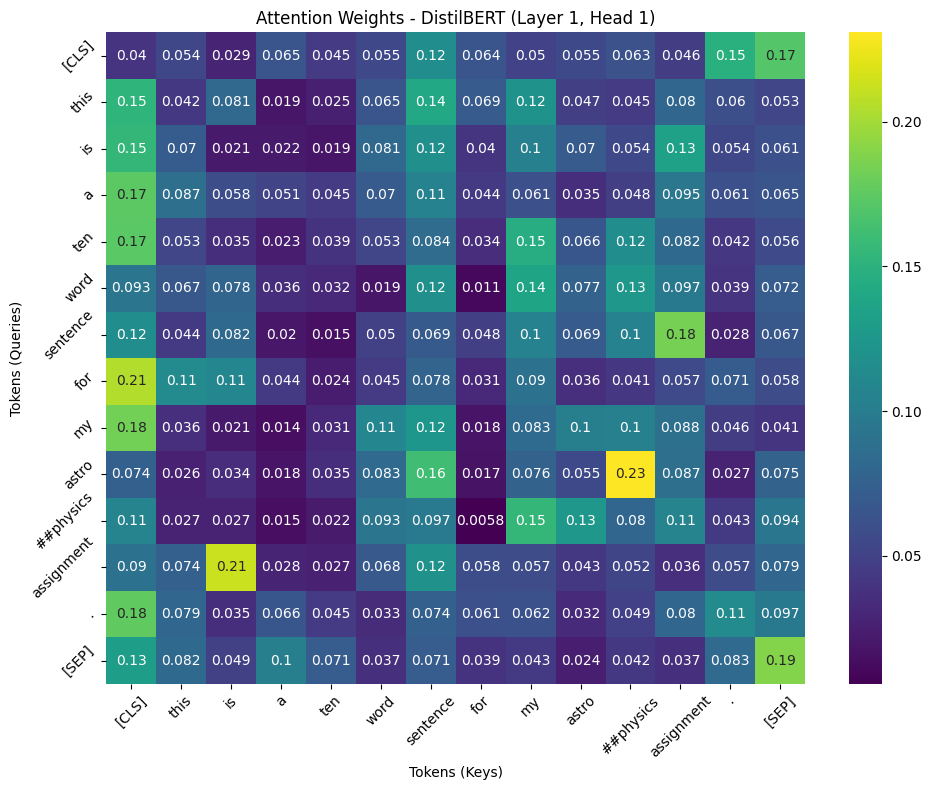

In [22]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Input a sentence
sentence = "This is a ten word sentence for my astrophysics assignment."

# 2. Tokenize the input sentence using DistilBERT's tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

# 3. Load DistilBERT model with output_attentions=True to get attention weights
model = DistilBertModel.from_pretrained("distilbert-base-uncased", output_attentions=True)

# 4. Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# 5. Extract attention weights from the output (attention weights for all layers)
attentions = outputs.attentions  # List of attention weights for each layer

# Let's take the attention weights from the first layer for visualization
attention_weights = attentions[0].squeeze(0).detach().numpy()  # Shape: (num_heads, seq_len, seq_len)

# 6. Visualize the attention weights from the first attention head
# We'll use the first head for simplicity, but you can also loop through other heads/layers
attention_head = attention_weights[0]  # (seq_len, seq_len)

# 7. Get the tokens (words) to be used as axis labels
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# 8. Plot the attention weights as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_head, annot=True, cmap="viridis", xticklabels=tokens, yticklabels=tokens)
plt.title("Attention Weights - DistilBERT (Layer 1, Head 1)")
plt.xlabel("Tokens (Keys)")
plt.ylabel("Tokens (Queries)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


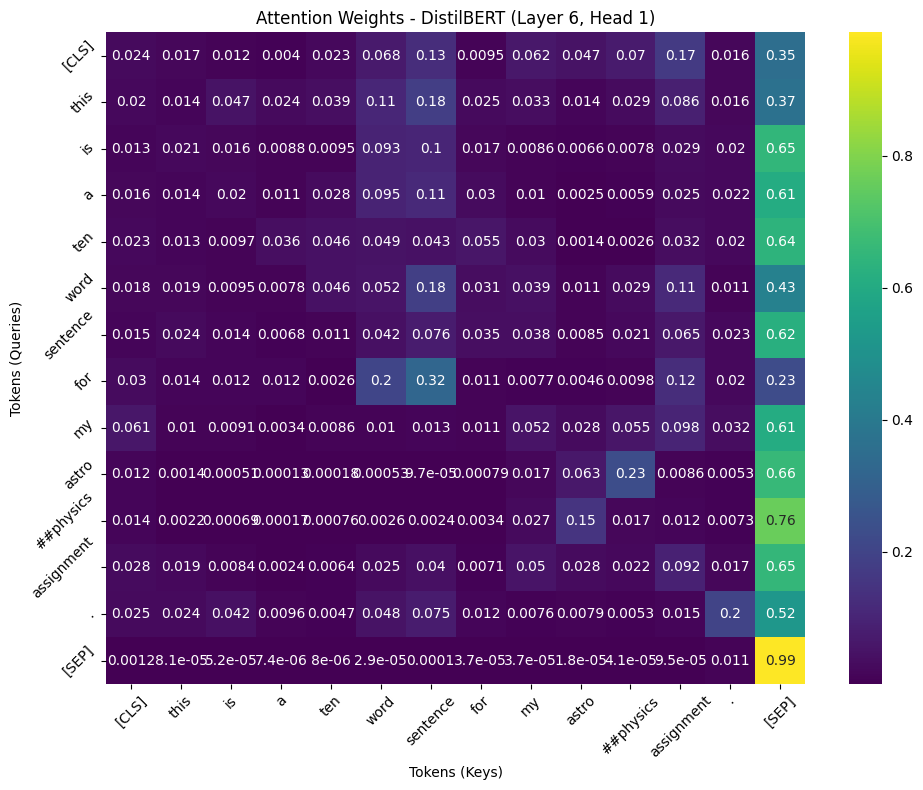

In [20]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Input a sentence
sentence = "This is a ten word sentence for my astrophysics assignment."

# 2. Tokenize the input sentence using DistilBERT's tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

# 3. Load DistilBERT model with output_attentions=True to get attention weights
model = DistilBertModel.from_pretrained("distilbert-base-uncased", output_attentions=True)

# 4. Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# 5. Extract attention weights from the output (attention weights for all layers)
attentions = outputs.attentions  # List of attention weights for each layer

attention_weights = attentions[2].squeeze(0).detach().numpy()  # Shape: (num_heads, seq_len, seq_len)

# 6. Visualize the attention weights from the first attention head of the 6th layer
attention_head = attention_weights[0]  # (seq_len, seq_len)

# 7. Get the tokens (words) to be used as axis labels
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# 8. Plot the attention weights as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_head, annot=True, cmap="viridis", xticklabels=tokens, yticklabels=tokens)
plt.title("Attention Weights - DistilBERT (Layer 6, Head 1)")
plt.xlabel("Tokens (Keys)")
plt.ylabel("Tokens (Queries)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# In this sentence, the token astro attends strongly to the word physics. This is not surprising, because the word astrophysics 
# is one that depends on both words, and it probably occurs often in the training data. 

# For deeper layers, all the tokens attend more strongly to the SEP token, wheras in the first layer, 
# all the tokens attend to each otehr seemingly uniformly. I have read that this is a common phenomena in certain models like BERT